In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io

import misc.bio as bio
import misc.parallel as parallel
import misc.utils as utils

import misc.math_utils as math_utils

In [3]:
def get_windows(profile):
    
    profile = profile / np.max(profile)
    
    orf_len = len(profile)
    if orf_len < 42:
        # we would return first window and exit
        first_window = profile[:21]
        return (first_window, None, None)

    first_window, middle_window, last_window = np.split(profile, [21, orf_len-21])

    # now, pull together and sum up all intermediate windows (of length 21)
    # cheat a bit, and just split split the middle into 21-bp windows, drop the last window
    indices = np.arange(21, len(middle_window), 21)
    middle_windows = np.split(middle_window, indices)[:-1]
    
    return first_window, middle_windows, last_window

def get_profile(orf, profiles):
    orf_num = orf['orf_num']
    orf_len = orf['orf_len']

    if orf_len < 21:
        return None

    profile = utils.to_dense(profiles, orf_num, length=orf_len)
    
    if sum(profile) < 5:
        return None
    
    return profile

def plot_windows(windows, title):

    windows_np = np.array(windows)
    first_windows = windows_np[:,0]
    
    #print(first_windows)

    last_windows = windows_np[:,2] 
    last_windows = np.array([lw for lw in last_windows if lw is not None])

    middle_windows = windows_np[:,1] 
    middle_windows = [mw for mw in middle_windows if mw is not None]
    middle_windows = utils.flatten_lists(middle_windows)
    middle_windows = np.array(middle_windows)

    ind = np.arange(21)  # the x locations for the groups
    width = 0.5       # the width of the bars

    fig, axes = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(10,5))

    # the first window
    first_means = np.mean(first_windows, axis=0)
    first_var = np.var(first_windows, axis=0)
    rects_first = axes[0].bar(ind, first_means, width, color='g', yerr=first_var)

    # the middle windows
    middle_means = np.mean(middle_windows, axis=0)
    middle_var = np.var(middle_windows, axis=0)
    rects_middle = axes[1].bar(ind, middle_means, width, color='g', yerr=middle_var)

    # the last window
    last_means = np.mean(last_windows, axis=0)
    last_var = np.var(last_windows, axis=0)
    rects_last = axes[2].bar(ind, last_means, width, color='g', yerr=last_var)

    axes[0].set_xlim((-width, 21))
    axes[0].set_ylim((0, 0.2))
    
    fig.suptitle(title)

In [4]:
#orfs_file = "/genomes/caenorhabditis_elegans/WBcel235.79.plus-de-novo/transcript-index/WBcel235.79.plus-de-novo.genomic-orfs.atg-only.bed.gz"
#profiles_file = "/prj/grosshans-riboseq/RPF/orf-profiles/9h-unique.length-17-20-21-28-29-33.offset-6-3-3-12-12-13.profiles.mtx"

#orfs_file = "/genomes/mus_musculus/GRCm38.79.plus-de-novo.genomic-orfs.atg-only.bed.gz"
#profiles_file = "/prj/shirin-riboseq/RPF/orf-profiles/mouse-325.swim.cm.de-novo-unique.length-25-29-30-32-33-34-35.offset-12-12-12-13-13-13-13.profiles.mtx"

orfs_file = "/genomes/homo-sapiens/GRCh38.79.plus-de-novo.genomic-orfs.atg-only.bed.gz"
profiles_file = "/prj/leo-riboseq/RPF/orf-profiles/tgfp-1-unique.length-17-18-19-20-21-22-23-24-26-28-29-30-31-32.offset-0-0-0-3-3-12-12-7-9-12-12-12-13-13.profiles.mtx"

orfs = bio.read_bed(orfs_file)
orf_type_groups = orfs.groupby('orf_type')
profiles = scipy.io.mmread(profiles_file).tocsr()

/home/bmalone/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [ ]:
orf_types = ['within'] # ['canonical', 'five_prime', 'noncoding'] # 'within']

for orf_type in orf_types:
    m_canonical = orfs['orf_type'] == orf_type
    m_reverse = orfs['strand'] == '-'
    m_seqname = orfs['seqname'] == 'I'
    g = orfs[m_canonical & m_reverse] # & m_seqname]
    
    %xdel windows
    %xdel g_profiles
    g_profiles = parallel.apply_df_simple(g, get_profile, profiles, progress_bar=True)
    g_profiles = [g_profile for g_profile in g_profiles if g_profile is not None]
    windows = parallel.apply_iter_simple(g_profiles, get_windows, progress_bar=True)

    title = '{}, reverse ({})'.format(orf_type, len(windows))
    plot_windows(windows, title)
    
    %xdel windows
    %xdel g_profiles
    g = orfs[m_canonical & ~m_reverse] # & m_seqname]
    g_profiles = parallel.apply_df_simple(g, get_profile, profiles, progress_bar=True)
    g_profiles = [g_profile for g_profile in g_profiles if g_profile is not None]
    windows = parallel.apply_iter_simple(g_profiles, get_windows, progress_bar=True)

    title = '{}, forward ({})'.format(orf_type, len(windows))
    plot_windows(windows, title)

NameError: name 'windows' is not defined
NameError: name 'g_profiles' is not defined
 16%|█▌        | 34655/216227 [00:11<01:02, 2912.81it/s]

In [5]:
orf_type = 'within'
m_canonical = orfs['orf_type'] == orf_type
m_reverse = orfs['strand'] == '-'
m_seqname = orfs['seqname'] == 'I'
g = orfs[m_canonical & m_reverse] # & m_seqname]


NameError: name 'windows' is not defined
NameError: name 'g_profiles' is not defined
100%|██████████| 16533/16533 [00:00<00:00, 18341.04it/s]


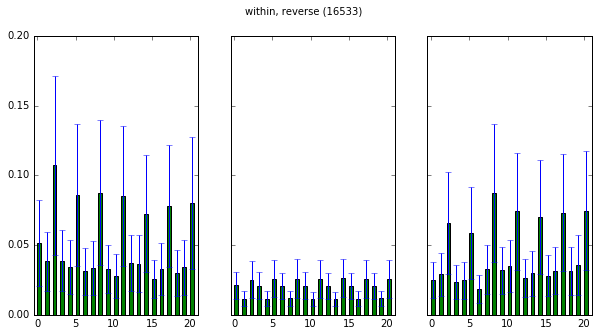

In [6]:
%xdel windows
%xdel g_profiles
g_profiles = parallel.apply_df_simple(g, get_profile, profiles, progress_bar=True)
g_profiles = [g_profile for g_profile in g_profiles if g_profile is not None]
windows = parallel.apply_iter_simple(g_profiles, get_windows, progress_bar=True)

title = '{}, reverse ({})'.format(orf_type, len(windows))
plot_windows(windows, title)

100%|██████████| 7989/7989 [00:01<00:00, 6199.56it/s]


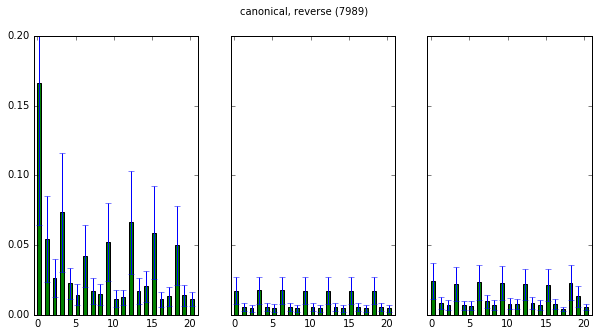

In [42]:
%xdel windows
%xdel g_profiles
g = orfs[m_canonical & ~m_reverse] # & m_seqname]
g_profiles = parallel.apply_df_simple(g, get_profile, profiles, progress_bar=True)
g_profiles = [g_profile for g_profile in g_profiles if g_profile is not None]
windows = parallel.apply_iter_simple(g_profiles, get_windows, progress_bar=True)

title = '{}, forward ({})'.format(orf_type, len(windows))
plot_windows(windows, title)

In [ ]:
def run_all(g, profiles, num_cpus=2):
    orf_type = g['orf_type'].iloc[0]

    g_profiles = parallel.apply_df_simple(g, get_profile, profiles, progress_bar=True)
    windows = parallel.apply_parallel_iter(g_profiles, num_cpus, get_windows, progress_bar=True)
    
    plot_windows(windows, orf_type)

In [ ]:
num_cpus = 2
orf_type_groups.apply(run_all, profiles, num_cpus)

In [ ]:
run_all(g, profiles)

In [ ]:
orf_type_groups.apply()

In [ ]:
run_all('canonical', orf_type_groups, profiles)

In [ ]:
run_all('five_prime_overlap', orf_type_groups, profiles)

In [ ]:
run_all('five_prime', orf_type_groups, profiles)

In [ ]:
run_all('three_prime_overlap', orf_type_groups, profiles)